In [32]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
# Check if GPU is available
output_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [33]:
names = open('names.txt','r').read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [34]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

In [35]:
# build dataset
block_size = 6 # context length: # of characters taken for prediction

def build_dataset(names):
    X, Y = [], []

    for name in names:
        context = [0] * block_size
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, Ytr = build_dataset(names[:n1]) # training set 80%
Xdev, Ydev = build_dataset(names[n1:n2]) # dev set 10%
Xte, Yte = build_dataset(names[n2:]) # test set 10%


In [36]:
# 'torch'ify the network syntax
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.name = 'Linear'
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.name = 'BatchNorm1d'
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __init__(self):
        self.name = 'Tanh'
        self.out = None
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Sigmoid:
    def __init__(self):
        self.name = 'Sigmoid'
        self.out = None
    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out
    def parameters(self):
        return []

class ReLU:
    def __init__(self):
        self.name = 'ReLU'
        self.out = None
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out
    def parameters(self):
        return []


In [37]:
n_emb = 10 # dimension of character embedding vectors
n_hidden = 100 # # of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

50551


In [38]:
# optimization
max_steps = 200000
batch_size = 32
bn_eps = 1e-5 # epsilon for numerical stability in batch normalization (/0 error)
lossi = []
ud = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] # character embeddings
    x = emb.view(emb.shape[0], -1) # concatenate embeddings
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
        
    # if i >= 1000:
    #     break



      0/ 200000: 3.3082


KeyboardInterrupt: 

layer 2 (      Tanh): mean -0.00, std 0.62, saturated: 3.47%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.75%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 1.88%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.31%


Text(0.5, 1.0, 'activation distribution')

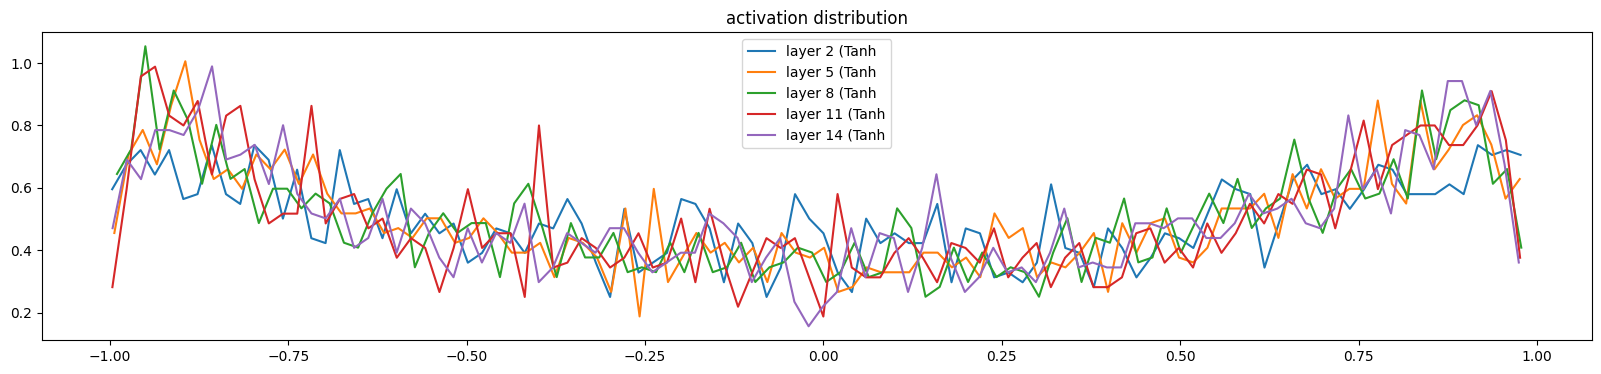

In [ ]:
# forward pass activation distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.974663e-03
layer 5 (      Tanh): mean +0.000000, std 2.680243e-03
layer 8 (      Tanh): mean -0.000000, std 2.438066e-03
layer 11 (      Tanh): mean +0.000000, std 2.327045e-03
layer 14 (      Tanh): mean +0.000000, std 2.238685e-03


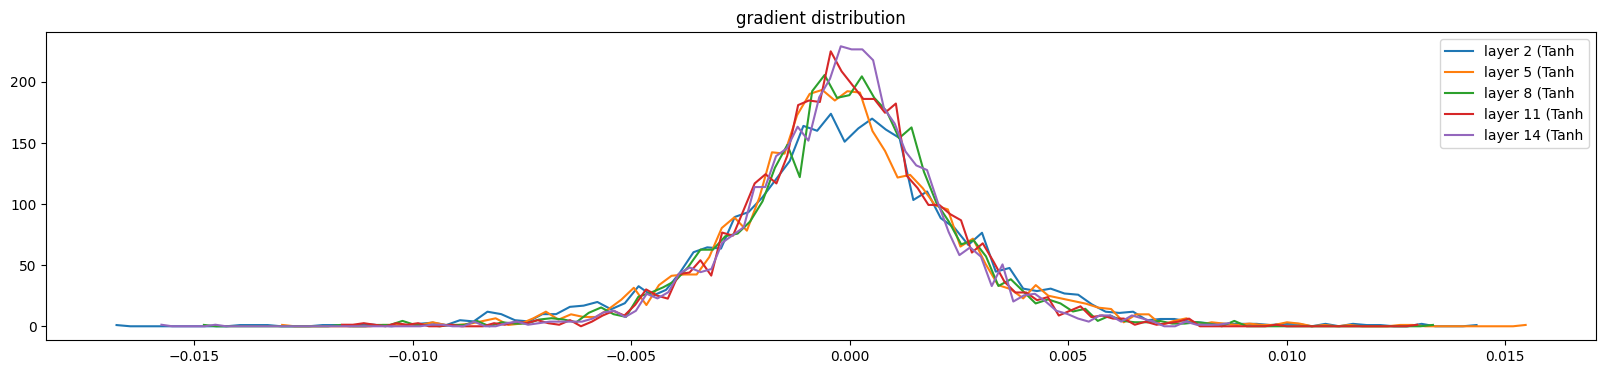

In [ ]:
# backward pass gradients distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean -0.000000 | std 8.507465e-03 | grad:data ratio 8.499605e-03
weight  (60, 100) | mean +0.000047 | std 6.422767e-03 | grad:data ratio 2.913756e-02
weight (100, 100) | mean -0.000015 | std 6.085153e-03 | grad:data ratio 3.646405e-02
weight (100, 100) | mean +0.000015 | std 5.546305e-03 | grad:data ratio 3.343548e-02
weight (100, 100) | mean +0.000022 | std 5.005433e-03 | grad:data ratio 2.996978e-02
weight (100, 100) | mean +0.000033 | std 4.538713e-03 | grad:data ratio 2.689461e-02
weight  (100, 27) | mean -0.000072 | std 8.584525e-03 | grad:data ratio 5.112359e-02


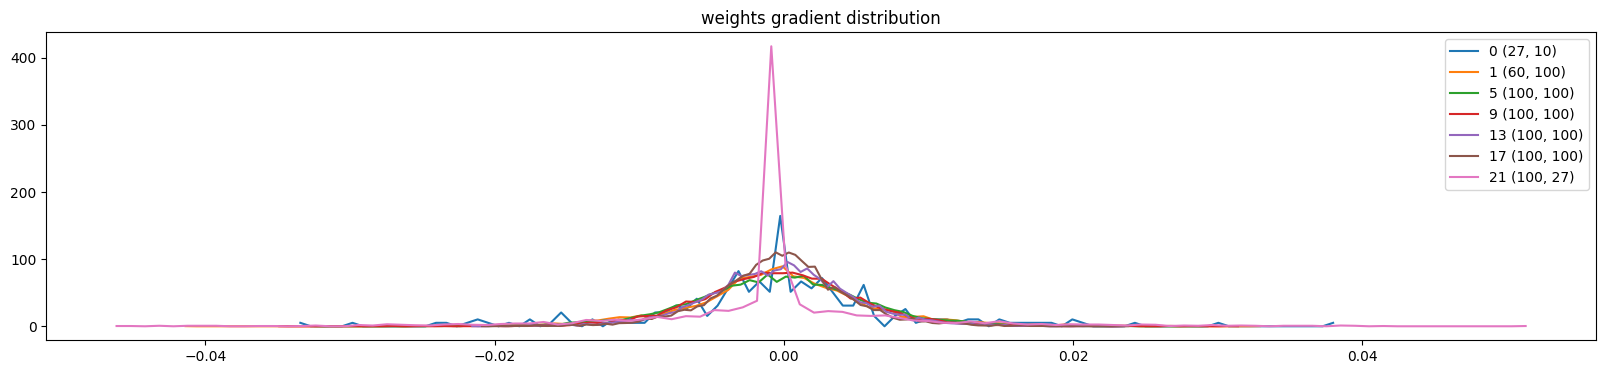

In [ ]:
# weights updated w/ SGD distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

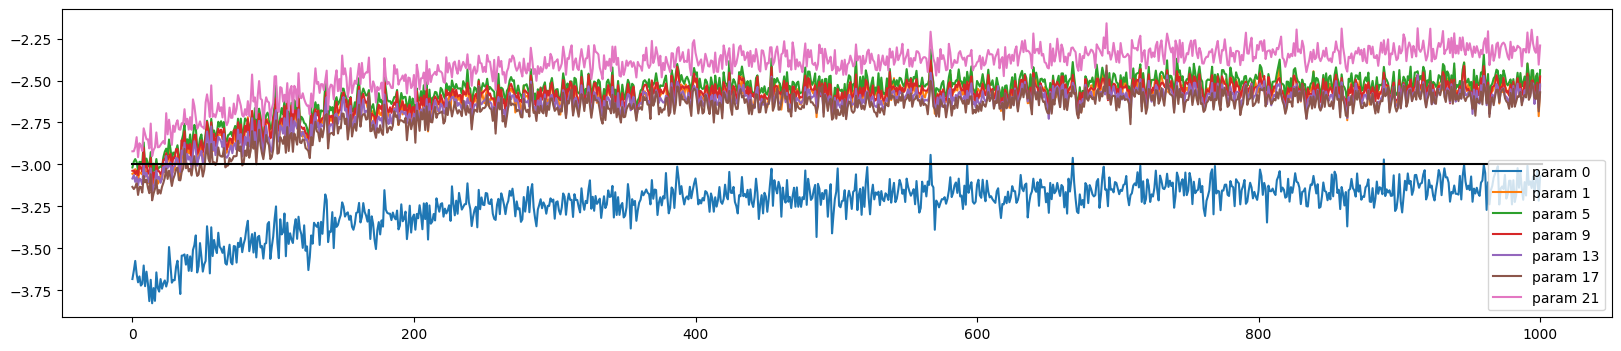

In [ ]:
# data update to data ratio
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
# loss evaluation
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4188647270202637
val 2.4130141735076904


In [ ]:
# model sampling
@torch.no_grad()
def sample_model(n):
    context = [0] * block_size
    for _ in range(n):
        out = []
        context = [0] * block_size
        while True:
            # forward pass
            emb = C[torch.tensor(context)]
            x = emb.view(1, -1) # concatenate embeddings
            for layer in layers:
                x = layer(x)
            logits = x
            probs = F.softmax(logits, dim=-1)

            # sampling
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # shift context
            context = context[1:] + [ix]
            if ix == 0:
                break
            out.append(itos[ix])
        print(''.join(out))
sample_model(20)

urynr
xaleya
yhrca
asezme
arrit
klhalhnr
deloner
oraynie
masvis
aoonehi
qxaaxzhe
esia
kailpnwe
grjen
pm
avsylan
dafily
haziih
jeanja
lazayle
